<a href="https://colab.research.google.com/github/hansenwandji/Data-visualisations/blob/main/Predict_stocks_usisng_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [7]:
!pip install --upgrade mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.1 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [8]:
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

In [17]:
# Reading our dataset
df = pd.read_csv(r"/content/preprocessed_CAC40.csv", parse_dates=['Date'])
df.head()

,Unnamed: 0,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
0,0,Accor,2020-04-03,22.99,23.40,23.40,22.99,67
1,1,Accor,2020-04-02,23.91,22.99,23.91,22.99,250
2,2,Accor,2020-04-01,24.10,23.83,24.10,23.83,37
3,3,Accor,2020-03-31,25.04,25.00,25.24,24.99,336
4,4,Accor,2020-03-30,26.50,25.02,26.50,24.99,415


## Preprocessing


In [14]:
# Check if 'Unnamed: 0' column exists before dropping
if 'Unnamed: 0' in df.columns:
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
else:
    print("Column 'Unnamed: 0' not found in DataFrame. Skipping drop operation.")

Column 'Unnamed: 0' not found in DataFrame. Skipping drop operation.


In [15]:
# Defining a function that will contain stocks data for a specific company
def specific_data(company, start, end):
    company_data = df[df['Name'] == company]
    date_filtered_data = company_data[(company_data['Date'] > start) & (company_data['Date'] < end)]
    return date_filtered_data

In [18]:
# Selecting any random company out of our 'Name' column
company_name = random.choice(df['Name'].unique().tolist())
# Setting the start and end date
start_date=dt.datetime(2014,1,1)
end_date=dt.datetime(2020,1,1)

# Calling our function
specific_df = specific_data(company_name, start_date, end_date)

In [19]:
specific_df.head()

,Unnamed: 0,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
57262,57262,Peugeot,2019-12-30,21.80,21.66,21.80,21.66,405
57263,57263,Peugeot,2019-12-27,21.92,21.99,21.99,21.92,500
57264,57264,Peugeot,2019-12-23,22.24,21.89,22.24,21.89,400
57265,57265,Peugeot,2019-12-20,22.28,22.23,22.28,22.23,344
57266,57266,Peugeot,2019-12-19,22.60,22.24,22.60,22.18,"2,758"


##Visualization


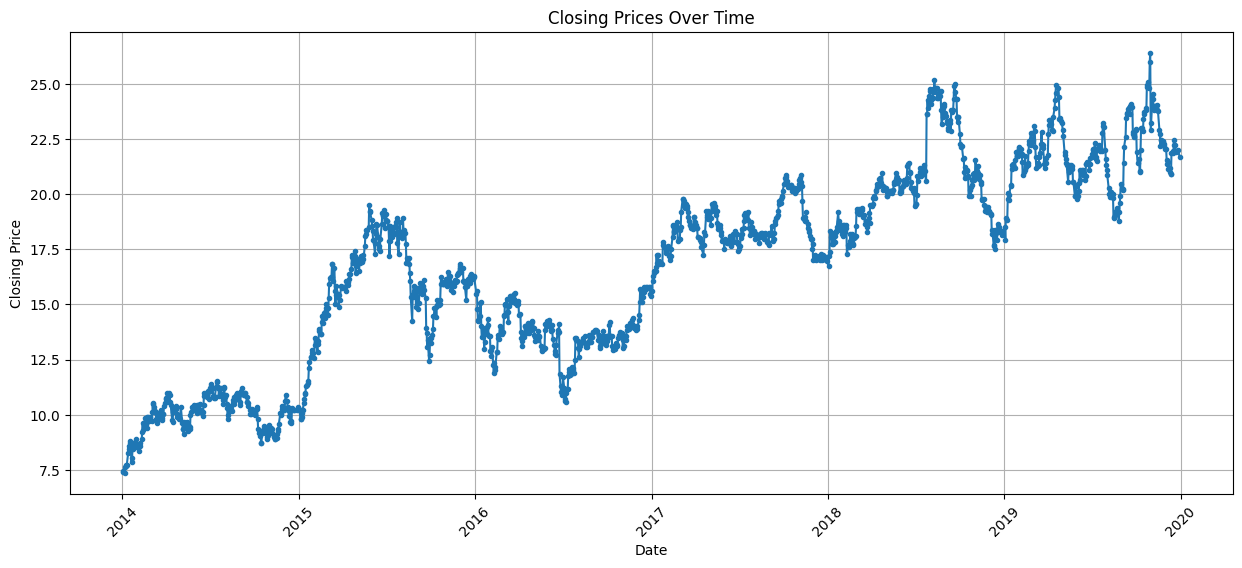

In [20]:
# Line Chart of Closing Prices Over Time

# Convert 'Date' column to datetime
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['Closing_Price'], marker='.')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

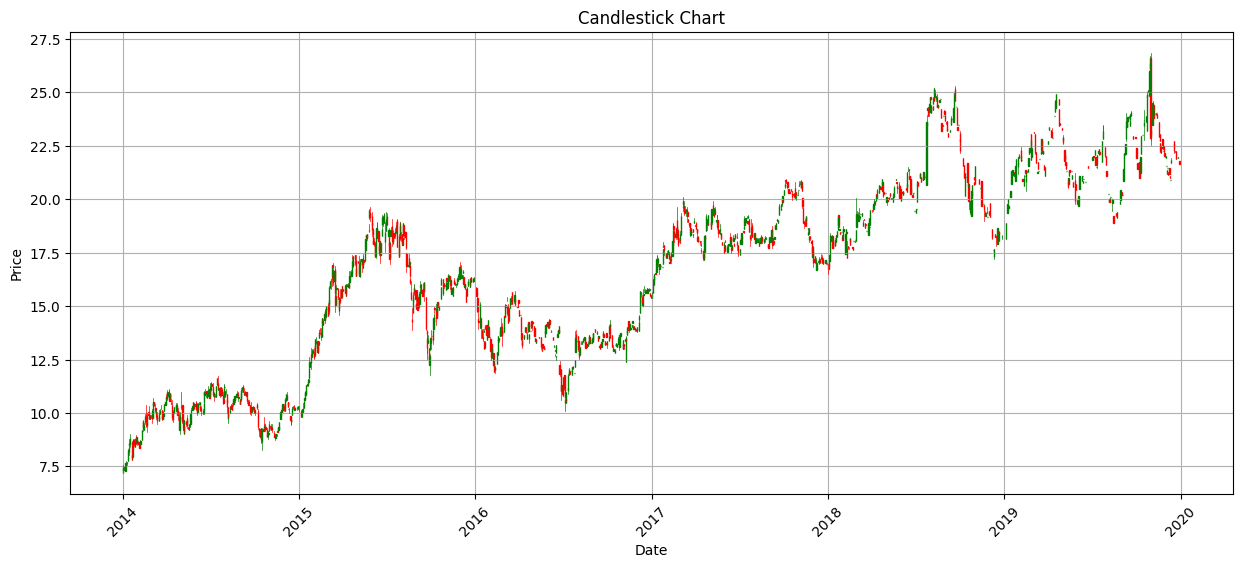

In [21]:
# Candlestick Chart

# Convert 'Date' column to matplotlib date format
matplotlib_date = mdates.date2num(specific_df['Date'])

# Create an array of tuples in the required format
ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['Daily_High'], specific_df['Daily_Low'], specific_df['Closing_Price'])).T

plt.figure(figsize=(15, 6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

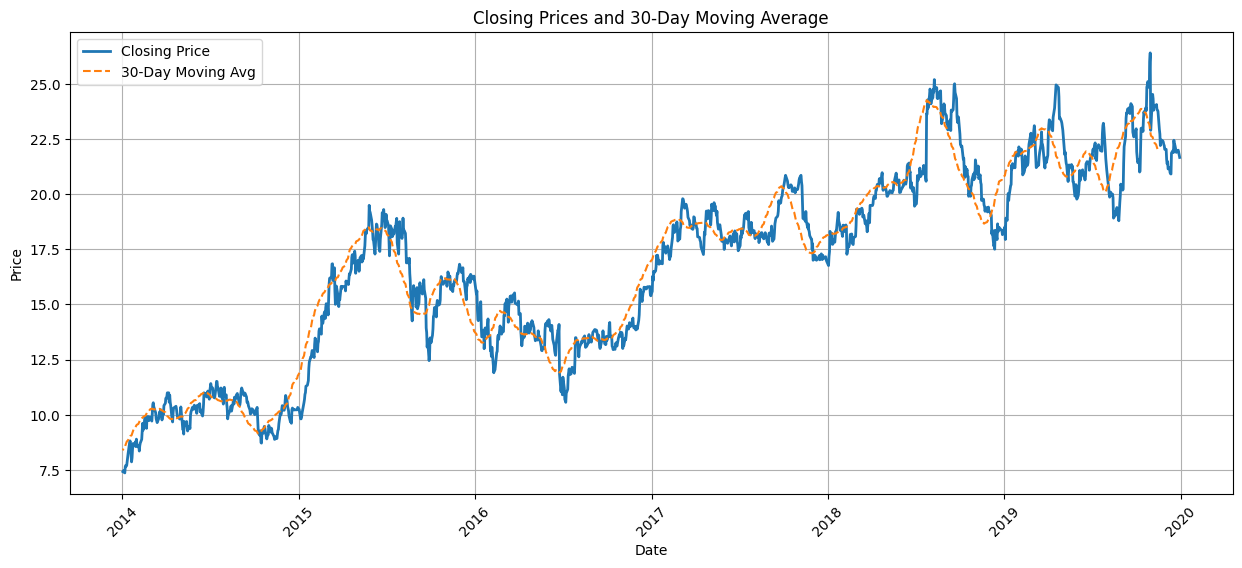

In [22]:
# Closing Prices and Moving Average plot

window = 30
plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['Closing_Price'], label='Closing Price', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Closing_Price'].rolling(window=window).mean(), label=f'{window}-Day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

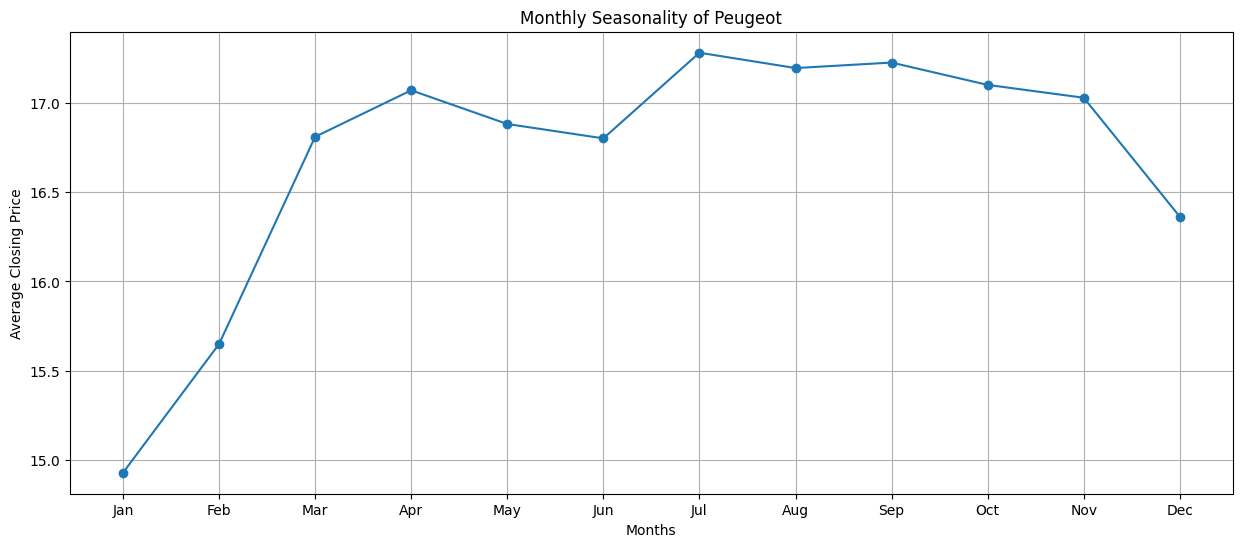

In [23]:
# Monthly Seasonality of Closing Prices
specific_df['Month'] = specific_df['Date'].dt.month

monthly_average = specific_df.groupby('Month')['Closing_Price'].mean()

plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title(f'Monthly Seasonality of {company_name}')
plt.xlabel('Months')
plt.ylabel('Average Closing Price')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

In [24]:
specific_df.head()

,Unnamed: 0,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume,Month
57262,57262,Peugeot,2019-12-30,21.80,21.66,21.80,21.66,405,12
57263,57263,Peugeot,2019-12-27,21.92,21.99,21.99,21.92,500,12
57264,57264,Peugeot,2019-12-23,22.24,21.89,22.24,21.89,400,12
57265,57265,Peugeot,2019-12-20,22.28,22.23,22.28,22.23,344,12
57266,57266,Peugeot,2019-12-19,22.60,22.24,22.60,22.18,"2,758",12


In [25]:
new_df = specific_df.reset_index()['Closing_Price']

In [26]:
# Normalizing our data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [27]:
# Split into training and testing sets
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [28]:
# Define the sequence length (number of past time steps)
n_past = 60

# Prepare sequences for LSTM
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [29]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1151, 60)
(1151,)


Testing set size:-
(243, 60)
(243,)


(None, None)

In [30]:
# Reshape input data for LSTM([samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

##Model Training

In [31]:
# Initialize a sequential model
model = Sequential()

# First LSTM layer with 50 units, input shape, and return sequences
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))         # Adding dropout to prevent overfitting

# Second LSTM layer with 50 units and return sequences
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer with 50 units
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(units=1))

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [43]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath = 'my_weights.h5', save_best_only = True)
# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our lstm model
model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0015

36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - loss: 0.0015 - val_loss: 3.4083e-04
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - loss: 0.0012 - val_loss: 3.8898e-04
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0014

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0014 - val_loss: 3.2964e-04
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0014

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0014 - val_loss: 3.2059e-04
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0011

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 0.0011 - val_loss: 3.0593e-04
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0013 - val_loss: 4.3864e-04
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 0.0011 - val_loss: 3.3995e-04
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0011 - val_loss: 4.3658e-04
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0011 - val_loss: 3.2031e-04
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0010 - val_loss: 7.0284e-04
Epoch 13/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 0.0013 - val_loss: 7.7242e-04
Epoch 14/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.0012 - val_loss: 3.8439e-04
Epoch 15/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0012 - val_loss: 3.3420e-04
Epoch 16/100
36/36 ━

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 9.8614e-04 - val_loss: 2.9305e-04
Epoch 17/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 9.9918e-04 - val_loss: 3.5569e-04
Epoch 18/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 8.9215e-04 - val_loss: 3.4543e-04
Epoch 19/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - loss: 0.0011 - val_loss: 8.2946e-04
Epoch 20/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 9.4258e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 9.4257e-04 - val_loss: 2.4495e-04
Epoch 21/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 8.7713e-04 - val_loss: 2.5114e-04
Epoch 22/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 9.5948e-04 - val_loss: 0.0021
Epoch 23/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 9.8772e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 9.8693e-04 - val_loss: 2.3840e-04
Epoch 24/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 8.7489e-04 - val_loss: 6.8203e-04
Epoch 25/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 9.4493e-04 - val_loss: 0.0014
Epoch 26/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 8.6002e-04 - val_loss: 0.0015
Epoch 27/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 9.5164e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - loss: 9.4874e-04 - val_loss: 2.2893e-04
Epoch 28/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0010 - val_loss: 6.9638e-04
Epoch 29/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 9.0572e-04 - val_loss: 2.3147e-04
Epoch 30/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 9.0588e-04 - val_loss: 2.9912e-04
Epoch 31/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 9.0637e-04 - val_loss: 2.5729e-04
Epoch 32/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 8.4979e-04 - val_loss: 3.6254e-04
Epoch 33/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 7.9115e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 7.9331e-04 - val_loss: 2.2329e-04
Epoch 34/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 7.3373e-04 - val_loss: 0.0011
Epoch 35/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 9.1182e-04 - val_loss: 4.0970e-04
Epoch 36/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 8.3811e-04 - val_loss: 3.1119e-04
Epoch 37/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 8.0712e-04 - val_loss: 3.0319e-04
Epoch 38/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 7.9075e-04 - val_loss: 4.2332e-04
Epoch 39/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 7.7798e-04 - val_loss: 9.4939e-04
Epoch 40/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 9.0491e-04 - val_loss: 8.3187e-04
Epoch 41/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 6.9416e-04 - val_loss: 3.6914e-04
Epoch 42/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 8.1263e-04 - val_loss: 4.9316e-04
Epoch 43/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 9

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 8.3304e-04 - val_loss: 2.1573e-04
Epoch 48/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 7.6880e-04 - val_loss: 2.8570e-04
Epoch 49/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 7.8769e-04 - val_loss: 9.0379e-04
Epoch 50/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - loss: 7.7420e-04 - val_loss: 8.6245e-04
Epoch 51/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 7.9251e-04 - val_loss: 2.4974e-04
Epoch 52/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 8.1507e-04 - val_loss: 7.3899e-04
Epoch 53/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - loss: 7.5926e-04 - val_loss: 2.4468e-04
Epoch 54/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 7.4277e-04 - val_loss: 6.5612e-04
Epoch 55/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 7.0451e-04 - val_loss: 3.1642e-04
Epoch 56/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 7.1031e-04 - val_loss: 5.9182e-04
Epoch 57/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 8.3685e-04 - val_loss: 2.1041e-04
Epoch 61/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 6.7907e-04 - val_loss: 0.0019
Epoch 62/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - loss: 7.3328e-04 - val_loss: 7.0015e-04
Epoch 63/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - loss: 6.4051e-04 - val_loss: 9.7298e-04
Epoch 64/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - loss: 6.9352e-04 - val_loss: 3.9905e-04
Epoch 65/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 6.4789e-04 - val_loss: 3.0935e-04
Epoch 66/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 6.8871e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 6.8862e-04 - val_loss: 1.9778e-04
Epoch 67/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - loss: 7.3117e-04 - val_loss: 2.5467e-04
Epoch 68/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 7.1039e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 7.1103e-04 - val_loss: 1.8633e-04
Epoch 69/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 7.9380e-04 - val_loss: 1.9850e-04
Epoch 70/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 7.6169e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 7.6143e-04 - val_loss: 1.8385e-04
Epoch 71/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 7.4904e-04 - val_loss: 6.5189e-04
Epoch 72/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 7.6131e-04 - val_loss: 5.7939e-04
Epoch 73/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 7.5679e-04 - val_loss: 4.6204e-04
Epoch 74/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 7.9569e-04 - val_loss: 1.8666e-04
Epoch 75/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 7.9628e-04 - val_loss: 5.3985e-04
Epoch 76/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 6.9975e-04 - val_loss: 3.3027e-04
Epoch 77/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 7.0138e-04 - val_loss: 6.2757e-04
Epoch 78/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 7.1821e-04 - val_loss: 3.0500e-04
Epoch 79/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 6.9401e-04 - val_loss: 7.2320e-04
Epoch 80/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - l

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 7.0463e-04 - val_loss: 1.8258e-04
Epoch 82/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 6.8189e-04 - val_loss: 1.8306e-04
Epoch 83/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 7.1672e-04 - val_loss: 1.8728e-04
Epoch 84/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 6.4437e-04 - val_loss: 1.8691e-04
Epoch 85/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 7.6201e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 7.6213e-04 - val_loss: 1.8011e-04
Epoch 86/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 7.6669e-04 - val_loss: 0.0015
Epoch 87/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - loss: 7.2302e-04 - val_loss: 3.7888e-04
Epoch 88/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 8.3439e-04 - val_loss: 1.9905e-04
Epoch 89/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - loss: 8.0951e-04 - val_loss: 2.5920e-04
Epoch 90/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 6.0454e-04 - val_loss: 2.0958e-04
Epoch 91/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 7.9233e-04 - val_loss: 3.8716e-04
Epoch 92/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 7.0015e-04 - val_loss: 6.2199e-04
Epoch 93/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 6.7810e-04 - val_loss: 7.0171e-04
Epoch 94/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 7.3539e-04 - val_loss: 6.6420e-04
Epoch 95/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 7

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 6.8917e-04 - val_loss: 1.7909e-04


In [38]:
# Let's do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [44]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [45]:
# Calculate train data RMSE
print(math.sqrt(mean_squared_error(y_train,train_predict)))
# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test,test_predict)))

17.5125440612169
9.762606981896031


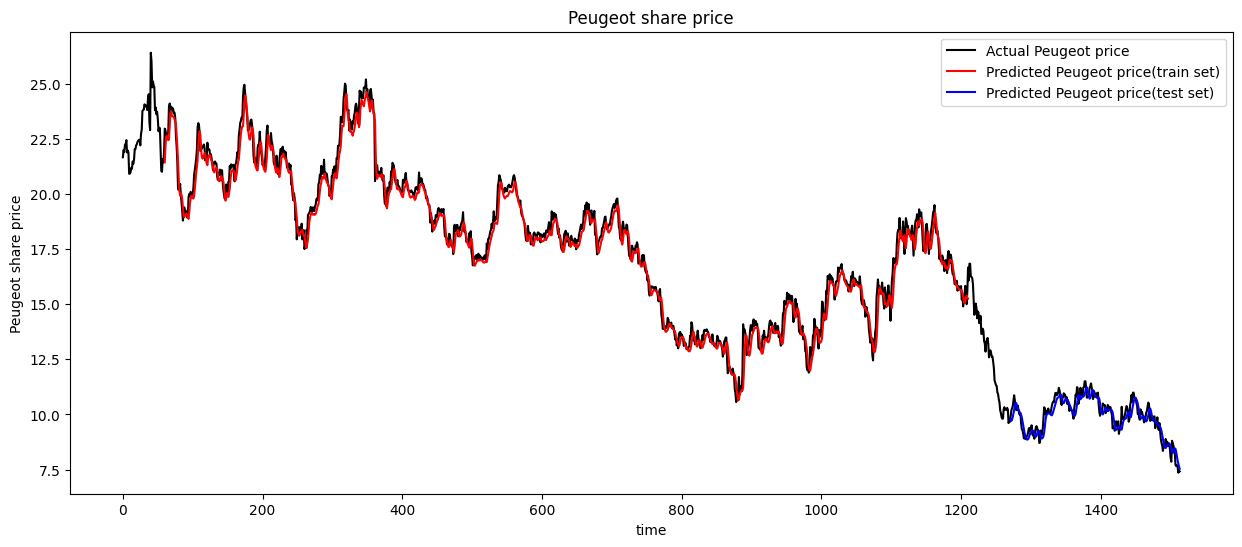

In [46]:
# Set the number of previous time steps to consider for plotting
look_back = 60

# Initialize an array for plotting the train predictions
trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:] = np.nan
# Assign the predicted values to the appropriate location for train predictions
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()


# Initialize an array for plotting the test predictions
testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
# Calculate the starting index for the test predictions
test_start = len(new_df) - len(test_predict)
# Assign the predicted values to the appropriate location for test predictions
testPredictPlot[test_start:] = test_predict.flatten()
# Rescale the scaled data back to its original scale using the scaler
original_scaled_data = scaler.inverse_transform(scaled_data)

# Plotting the baseline data, training predictions, and test predictions
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual {company_name} price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted {company_name} price(train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted {company_name} price(test set)")

plt.title(f"{company_name} share price")
plt.xlabel("time")
plt.ylabel(f"{company_name} share price")
plt.legend()
plt.show()

In [47]:
# To predict for the next 10 days, we'll need the last n_past days of data
last_sequence = X_test[-1]

# Reshape the last_sequence to match the input shape of the model
last_sequence = last_sequence.reshape(1, n_past, 1)

# Generate predictions for the next 10 days
predictions_next_10_days = []
for _ in range(10):
    next_day_prediction = model.predict(last_sequence)
    predictions_next_10_days.append(next_day_prediction[0, 0])  # Get the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1)  # Shift the sequence by one day
    last_sequence[0, -1, 0] = next_day_prediction  # Update the last element with the new prediction
# Transform the predictions back to the original scale
predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))

# Print the predictions for the next 10 days
print("Predictions for the next 10 days:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predictions for the next 10 days:
Day 1: Predicted Price = 7.534562587738037
Day 2: Predicted Price = 7.587467193603516
Day 3: Predicted Price = 7.639008522033691
Day 4: Predicted Price = 7.677146911621094
Day 5: Predicted Price = 7.703711032867432
Day 6: Predicted Price = 7.723742485046387
Day 7: Predicted Price = 7.741493225097656
Day 8: Predicted Price = 7.759361743927002
Day 9: Predicted Price = 7.778069972991943
Day 10: Predicted Price = 7.797341346740723


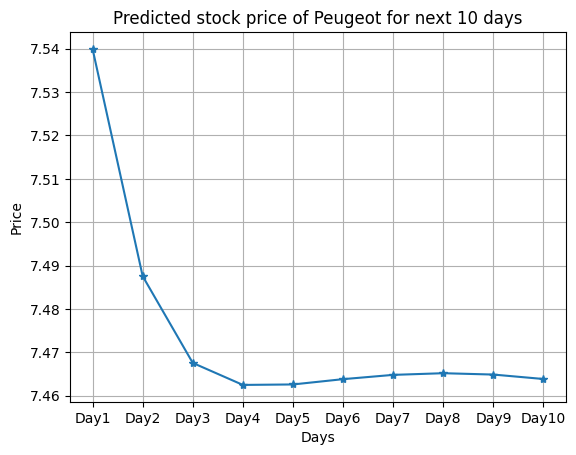

In [41]:
plt.plot(predictions_next_10_days, marker='*')
plt.title(f'Predicted stock price of {company_name} for next 10 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 10), ['Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10'])
plt.grid(True)
plt.show()